# Prediction customer churn ¶
This code is geared to detect customers which are highly likely to change and take action respectively. The data set used below was downloaded in the Kaggle and consists of 19 columns(exogenous variables) and the churn (endogenous variable).



In [1]:
# import the all below libraries which will be applied for prediction and analysis
import pandas as pd 
import numpy as np
import math
import re 
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics.cluster import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage 
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [2]:
#import the data set into a pandas data frame
data = pd.read_csv(r'C:\Users\Admin\OneDrive\Рабочий стол\DataScience\WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
# have a look at the loaded dataset
data.head(100)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8637-XJIVR,Female,0,No,No,12,Yes,Yes,Fiber optic,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,78.95,927.35,Yes
96,9803-FTJCG,Male,0,Yes,Yes,71,Yes,Yes,DSL,Yes,...,No,Yes,No,No,One year,Yes,Credit card (automatic),66.85,4748.7,No
97,0278-YXOOG,Male,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,21.05,113.85,Yes
98,3212-KXOCR,Male,0,No,No,52,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),21.00,1107.2,No


In [4]:
# checking unique values of each column
for column in data.columns:
    print('Column: {} - Unique Values:{}'.format(column, data[column].unique()))

Column: customerID - Unique Values:['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Column: gender - Unique Values:['Female' 'Male']
Column: SeniorCitizen - Unique Values:[0 1]
Column: Partner - Unique Values:['Yes' 'No']
Column: Dependents - Unique Values:['No' 'Yes']
Column: tenure - Unique Values:[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Column: PhoneService - Unique Values:['No' 'Yes']
Column: MultipleLines - Unique Values:['No phone service' 'No' 'Yes']
Column: InternetService - Unique Values:['DSL' 'Fiber optic' 'No']
Column: OnlineSecurity - Unique Values:['No' 'Yes' 'No internet service']
Column: OnlineBackup - Unique Values:['Yes' 'No' 'No internet service']
Column: DeviceProtection - Unique Values:['No' 'Yes' 'No internet service']
Column: TechSupport - Unique V

In [5]:
# general information of the data frame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


As shown above, the data set contains 7043 observations and 21 columns:
- there is not null objects on the data set;
- TotalCharges column has been detected as an object;
For avoiding mistakes in further analysis, it is necessary to transform the column into a numeric data type.

In [6]:
# For the column transformation the pd.to_numeric is being applied.
#This function raises an exception when it stumbles across an non-numeric variables.
#To avert it the 'coerce' overlooks this case and replace it with NAN

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors ='coerce')

In [7]:
#Now there are 11 missing objects.
data[data['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


As it shown above, these observations have a tenure of 0 and 'MonthlyCharges' is not null. It apparently contradicts with 'TotalCharges', and hence it will be written off as human factor. 

In [8]:
#dropping observations with null variables 
data.dropna(inplace=True)

In [9]:
#CustomerID column is pointless for churn explanation. It will be removed
data.drop(columns="customerID", inplace=True)

In [10]:
#PaymentMethod has a disadvantage or predicament like 'automatic'
#It will be removed 
data.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [11]:
data['PaymentMethod'] = data['PaymentMethod'].str.replace(' (automatic)', '', regex=False)

In [12]:
data.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

The following bar plot will reflect the percentage of obvervations that corresponds to each class of the reponse variable 'no' and 'yes'.

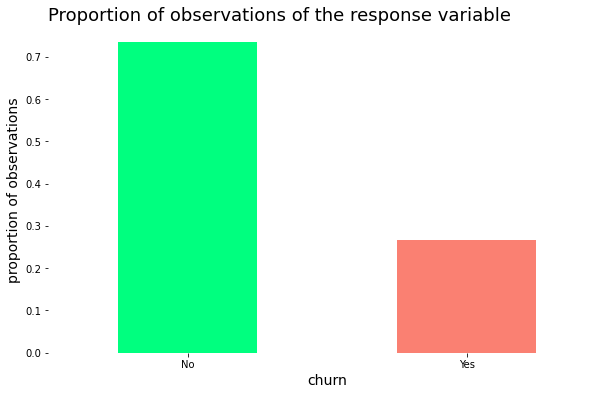

In [13]:
# figure creation
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)


#take the churn values to look at the proportion of each class 
prop_response = data['Churn'].value_counts(normalize=True)

#bar plot creation depicting the percentage of churn 
prop_response.plot(kind='bar',
                  ax=ax,
                  color=['springgreen', 'salmon'])

# title setting and labels assignment part 
ax.set_title('Proportion of observations of the response variable',
            fontsize=18, loc='left')
ax.set_xlabel('churn',
             fontsize=14)
ax.set_ylabel('proportion of observations',
             fontsize=14)
ax.tick_params(rotation = 'auto')


#eliminating the frame from the plot
spine_names = ('top', 'right', 'bottom', 'left')

for spine_name in spine_names:
    ax.spines[spine_name].set_visible(False)

From the data set we can derive useful information picking each attribute such as 'gender', 'SeniorCitizen', 'Partner', Dependents'showing the percentage of 'Churn' for each category of the abovementioned atrributes.

In [14]:
def percentage_stacked_plot(columns_to_plot, super_title):
    
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)
    
    #figure creation
    fig = plt.figure(figsize=(12, 5 * number_of_rows))
    fig.suptitle(super_title, fontsize=22, y=.95)
    
    #loop to each column name to create a subplot 
    for index, column in enumerate(columns_to_plot, 1):
        
        
        # the subplot creation
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        
        #the percetage calculation of the number of observation of the response variable for each group of the exogenous variable
        #this is 100% stacked bar plot
        prop_by_independent = pd.crosstab(data[column], data['Churn']).apply(lambda x: x/x.sum()*100, axis=1)
                                         
        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                rot=0, color=['springgreen', 'salmon'])
        
        #legend setting in the upper right corner                        
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                 title='Churn', fancybox=True)
        
        #titles setting and lables                                 
        ax.set_title('Proportion of observations by' + column,
                    fontsize=16, loc='left')
        ax.tick_params(rotation='auto')
        
        #frame eliminating from the plot
        spine_names = ('top','right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

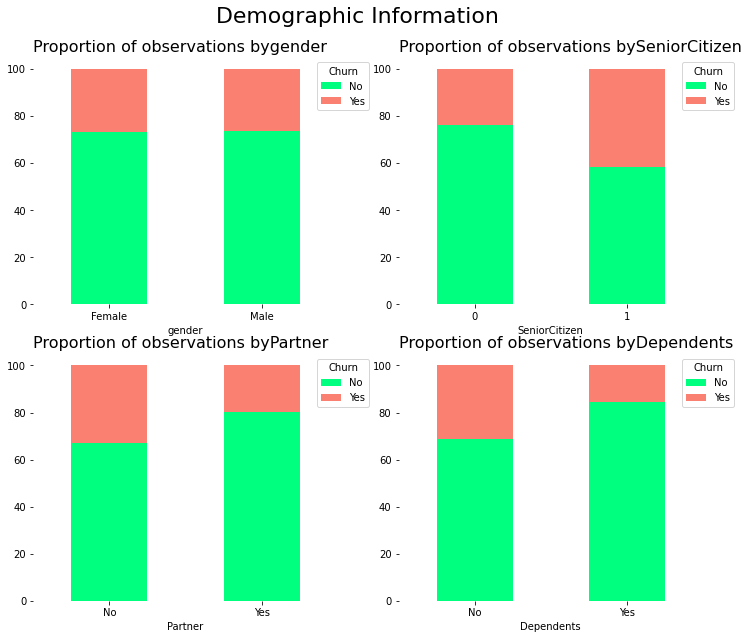

In [15]:
#demographic attributes titles 
demographic_columns = ['gender', 'SeniorCitizen','Partner', 'Dependents']

#stacked plotting of demographic columns
percentage_stacked_plot(demographic_columns, 'Demographic Information')

The first inference from the exctracted data:
- 'Gender' does not have a significant predictive power. Churn percentage is shown both when a customer is a man or woman;
- However, the different picture is being viewed into 'SeniorCitizen' column doubling that of young citizens;
- As for Partner atrribute, customers with a partner are less prone to leave the company than customers without one. 

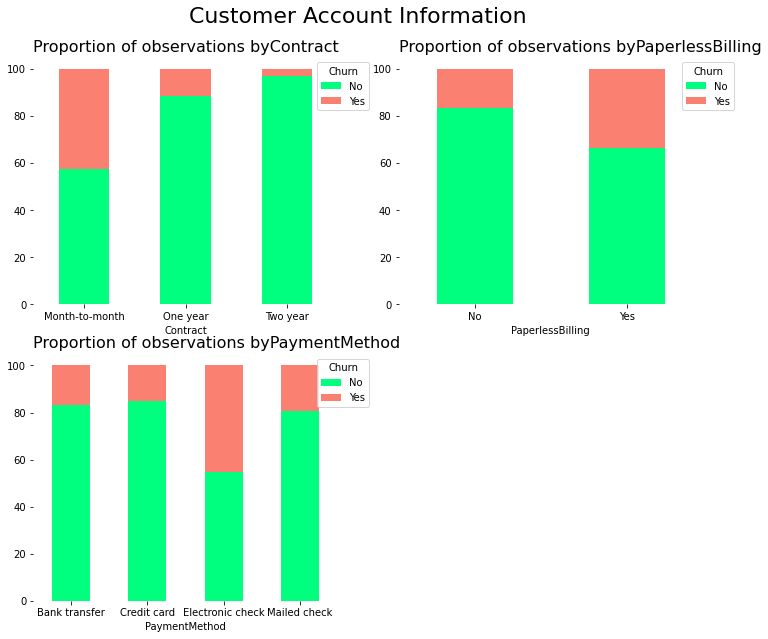

In [16]:
# the same will be done with categorical variables 
account_columns = ['Contract', 'PaperlessBilling', 'PaymentMethod']

percentage_stacked_plot(account_columns, 'Customer Account Information')

The second round of inferences:
- Customers with month-to-month contracts have higher churn rates in comparison with clients having yearly lasting contracts;
- Customers opting for an electronic check as payments system are more prone to leave the company;
- Paperless billing makes people to churn compay.

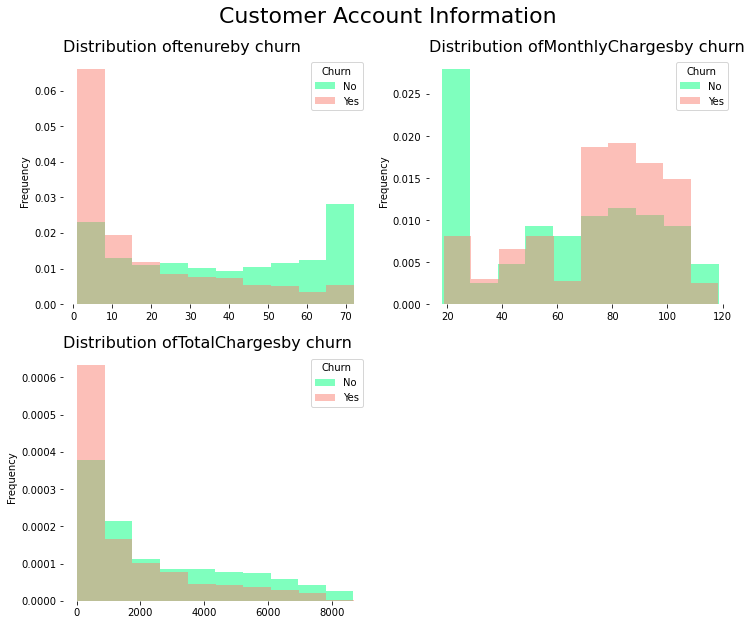

In [17]:
def histogram_plots(columns_to_plot, super_title):
    
    #setting the number of both rows and columns
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)
    
    
    #figure creation
    fig = plt.figure(figsize=(12, 5* number_of_rows))
    fig.suptitle(super_title, fontsize=22, y=.95)
    
    
    #looping part to each demographic column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):
        
        
        #subploat creation
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        
        
        #normalized histogram depicting each class
        data[data['Churn'] == 'No'][column].plot(kind= 'hist', ax=ax, density=True,
                                                alpha=0.5, color='springgreen', label='No')
        data[data['Churn'] == 'Yes'][column].plot(kind='hist', ax=ax, density=True,
                                                 alpha=0.5, color='salmon', label='Yes')
        
        #legend setting in the upper right corner
        ax.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)
        
        
        #labels and titles setting 
        ax.set_title('Distribution of' + column + 'by churn',
                    fontsize=16, loc='left')
        
        ax.tick_params(rotation='auto')
        
        
        #elininating the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)
            
            

#customer account column names            
account_columns_numeric=['tenure', 'MonthlyCharges', 'TotalCharges']

#histogram of customer account columns 
histogram_plots(account_columns_numeric, 'Customer Account Information')
            

            
            
        
    


The third round inference conclusion:
- New clients according to tenure are more likely to quite the company;
- The higher monthly charges the higher churn rate;
- However, cliens paying higher total charges are less likely to leave the company.

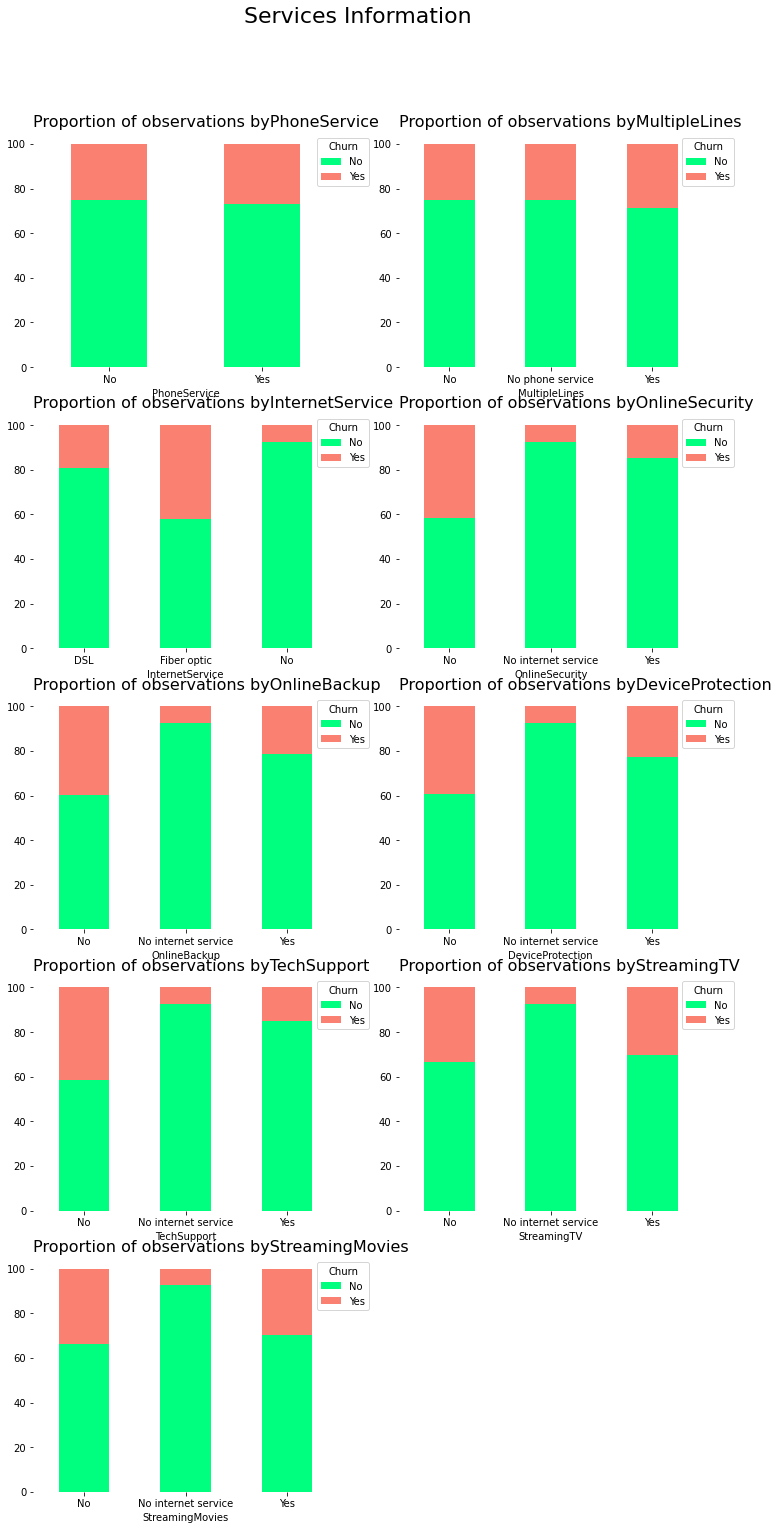

In [18]:
# checking churn by rendering different range of services 
services_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
percentage_stacked_plot(services_columns, 'Services Information')

The fourth round of inference:
- It is apparently that phone services don't have a significant predictive power. The churn percentage for the whole related phone service is almost the same;
- For some reasons, clients with fiber optic are more prone to leave the company than who has DSL;
- As for precense of online security system, clients without this service are obviously leaving the company than who has it;
- Customers without tech support on spot tend to churn more often than those with tech support.

In ML is highly important to know the mutual dependencies between variables based on entropy indicator. The higher the dependency degree the higher predicting power. 

In [19]:
#the function counting the information score between a categorical columns and 'Churn'
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, data.Churn)

#pick whole categorical variables excluding the response variable
categorical_variables = data.select_dtypes(include=object).drop('Churn', axis=1)

feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)
print(feature_importance)

Contract            0.098182
OnlineSecurity      0.064528
TechSupport         0.062873
InternetService     0.055394
OnlineBackup        0.046659
PaymentMethod       0.044423
DeviceProtection    0.043784
StreamingMovies     0.031918
StreamingTV         0.031803
PaperlessBilling    0.019119
Dependents          0.014270
Partner             0.011383
MultipleLines       0.000798
PhoneService        0.000069
gender              0.000037
dtype: float64


As we can see that 'gender' and phone related services don't have a strong relationship with the 'Churn'

Having done the brief data overview, it is high time to prepare data for teaching machine encoding categorical variables into nunerical ones.

In [20]:
data_copy = data.copy()

#label encoding
label_encoding_columns = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'PhoneService','Churn']


#maping 
for column in label_encoding_columns:
    if column == 'gender':
        data_copy[column] = data_copy[column].map({'Female':1, 'Male':0})
    else:
        data_copy[column] = data_copy[column].map({'Yes':1, 'No':0})
        

One-hot encoding creates a new binary column for each level of the categorical variable. Binary variables(dummy ones) such as '0' and '1' depicting absence or presence of the category in the data set.

In [21]:
# one-hot encoding
one_hot_encoding_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                           'DeviceProtection', 'TechSupport', 'StreamingTV',  'StreamingMovies', 'Contract', 'PaymentMethod']
data_copy = pd.get_dummies(data_copy, columns = one_hot_encoding_columns)

In [22]:
# data normalization to avoid the overpowering large-scale numeric data over low-scale data employing min-max approach
min_max_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

for column in min_max_columns:
    min_column = data_copy[column].min()
    max_column = data_copy[column].max()
    
    data_copy[column] = (data_copy[column] - min_column) / (max_column - min_column)

In [23]:
#creating the variable 'x' to store the independent attributes of the dataset
x = data_copy.drop(columns='Churn')
#creating the variable 'y' to store the dependent attribut 'Churn'
y=data_copy.loc[:,'Churn']
print(x.columns)
print(y.name)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer',
       'PaymentMethod_Credit card', 'Paym

In [24]:
#splitiing data under the conventional proportion 75 % - train and 25 % test
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25,
                                                random_state=40, shuffle=True)

In [25]:
data_copy.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,0.000000,0,1,0.115423,0.001275,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0.464789,1,0,0.385075,0.215867,0,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0.014085,1,1,0.354229,0.010310,1,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0.619718,0,0,0.239303,0.210241,0,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,0.014085,1,1,0.521891,0.015330,1,...,1,0,0,1,0,0,0,0,1,0


In [26]:
# choosing a most suitable approach for out dataset to teach machine;
# there is taken only those which are embeded under scikit-learn library 
def create_models(seed=2):
    
    models=[]
    models.append(('dummy_classifier', DummyClassifier(random_state=seed, strategy='most_frequent')))
    models.append(('k_nearest_neighbors', KNeighborsClassifier()))
    models.append(('logistic_regression', LogisticRegression(random_state=seed)))
    models.append(('support_vector_machines', SVC(random_state=seed)))
    models.append(('random_forest', RandomForestClassifier(random_state=seed)))
    models.append(('gradient_boosting', GradientBoostingClassifier(random_state=seed)))
    
    return models
models = create_models()
    

In [27]:
# test the accuracy of each model utilizing a default hyperparameters
results=[]
names=[]
scoring='accuracy'

for name, model in models:
    model.fit(x_train, y_train).predict(x_test)
    predictions=model.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    results.append(accuracy)
    names.append(name)
    
    print('Classifier: {}, Accuracy:{})'.format(name, accuracy))

Classifier: dummy_classifier, Accuracy:0.745164960182025)
Classifier: k_nearest_neighbors, Accuracy:0.7531285551763367)


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Classifier: logistic_regression, Accuracy:0.7923777019340159)
Classifier: support_vector_machines, Accuracy:0.7878270762229806)
Classifier: random_forest, Accuracy:0.7713310580204779)
Classifier: gradient_boosting, Accuracy:0.7963594994311718)


In [28]:
#Since the Gradient Boosting depicted the best accuracy level this model will be used;
#let's define the parameter grid
grid_parameters = {'n_estimators':[80, 90, 100, 110, 115, 120],
                  'max_depth':[3,4,5,6],
                  'max_features':[None, 'auto', 'sqrt', 'log2'],
                  'min_samples_split':[2,3,4,5]}


#Determining the RandomizedSearchCV class for bidding different parameters combinations
random_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                  param_distributions=grid_parameters,
                                  cv=5,
                                  n_iter=150,
                                  n_jobs=-1)

#fitting the model for random search
random_search.fit(x_train, y_train)

print(random_search.best_params_)

{'n_estimators': 90, 'min_samples_split': 3, 'max_features': 'sqrt', 'max_depth': 3}


Having fitted the grid object, I received the best hyperparameters 

Another important step is assesing the performance of the model using confusion matrix
which assesses the number of observations that are correctly or incorrectly classified. In binary classification the confusion matrix us a 2-by-2 matrix composed of 4 elements:
- TP - correctly classified (example: person has an iphone > whealthy)
- TN - correctly classified (example: person does not have an iphone > poor)
- FP - wrongly classified (example: number of people who are incorectly classified as whelthy)
- FN - wrongly classified (example: people with an iphone are classified as poor)

In [29]:
# making prediction
random_search_predictions = random_search.predict(x_test)
#confusion matrix construction 
confusion_matrix = confusion_matrix(y_test, random_search_predictions)

confusion_matrix

array([[1150,  160],
       [ 193,  255]], dtype=int64)

As shown above, 1405 observations of the testing data were correctly classified by the model (1150+255) and 353 misclassifications.

In [30]:
print(classification_report(y_test, random_search_predictions))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1310
           1       0.61      0.57      0.59       448

    accuracy                           0.80      1758
   macro avg       0.74      0.72      0.73      1758
weighted avg       0.79      0.80      0.80      1758



In [31]:
accuracy_score(y_test, random_search_predictions)

0.7992036405005688